In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine,func,inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Collect the names of tables within the database
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
# Using the inspector to print the column names within the 'measurement' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [13]:
# Latest Date
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date

('2017-08-23')

In [14]:
# Calculate the date 1 year ago from the last data point in the database
import datetime as dt
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days = 365)
print(year_ago)

2016-08-23


In [15]:
# Perform a query to retrieve the date and precipitation scores
# Sort the dataframe by date
sel = [Measurement.date,
       func.sum(Measurement.prcp)]
date_prcp = session.query(*sel).\
    filter(Measurement.date >= '2016-08-23').\
    filter(Measurement.date <= '2017-08-23').\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()

In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column
measurement_df = pd.DataFrame(date_prcp, columns = ['date','precipitation'])
measurement_df.set_index('date', inplace=True)
measurement_df.head()

,precipitation
date,
2016-08-23,2.71
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32


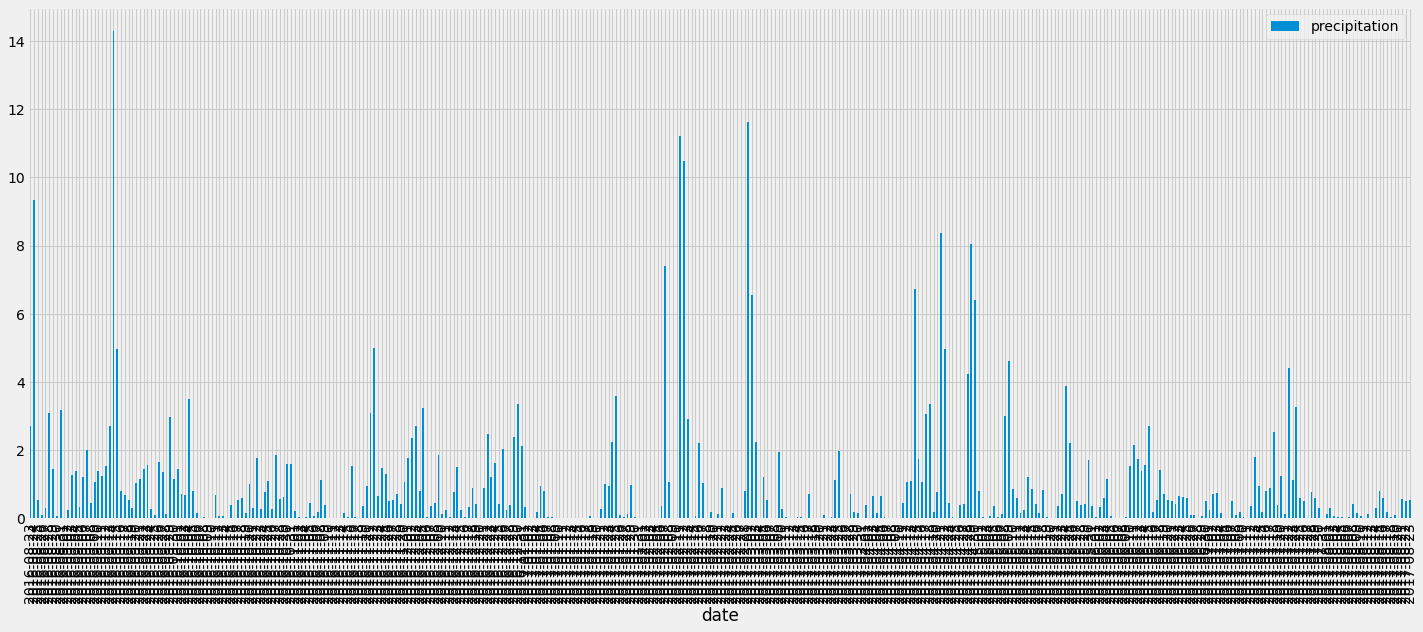

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data

measurement_df.plot(kind="bar", figsize=(20,9))
plt.tight_layout()
plt.show()

In [18]:
#Use Pandas to print the summary statistics for the precipitation data
measurement_df.describe()

,precipitation
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


## *Station Analysis*

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
conn = engine.connect()
measurement_data = pd.read_sql("SELECT * FROM measurement", conn)
measurement_data.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [20]:
measurement_data.describe()

,id,prcp,tobs
count,19550.000000,18103.000000,19550.000000
mean,9775.500000,0.160644,73.097954
std,5643.743217,0.468746,4.523527
min,1.000000,0.000000,53.000000
25%,4888.250000,0.000000,70.000000
50%,9775.500000,0.010000,73.000000
75%,14662.750000,0.110000,76.000000
max,19550.000000,11.530000,87.000000


In [21]:
# Design a query to show how many stations are available in this dataset?
from sqlalchemy import distinct
session.query(func.count(distinct(Measurement.station))).all()

[(9)]

In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_station = session.query(Measurement.station).\
          group_by(Measurement.station).\
          order_by(Measurement.station.desc()).first()
most_active_station

('USC00519523')

In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
from sqlalchemy import func
min_tem = session.query(func.min(Measurement.tobs)).filter_by(station = 'USC00519523').all()
max_tem = session.query(func.max(Measurement.tobs)).filter_by(station = 'USC00519523').all()
avg_tem = session.query(func.avg(Measurement.tobs)).filter_by(station = 'USC00519523').all()
avg_tem

[(74.5436493068565)]

In [33]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_tobs = measurement_data["tobs"].max()
stations = session.query(distinct(Measurement.station)).filter_by(tobs =highest_tobs).all()
stations

[('USC00519397'), ('USC00517948'), ('USC00511918')]

In [41]:
hist_df = measurement_data.loc[measurement_data["station"]== "USC00519523", ["date","tobs"]]
hist_df = hist_df.loc[(hist_df["date"]>= "2016-08-23")&(hist_df["date"]<= "2017-08-23") , :]
hist_df

,date,tobs
11850,2016-08-23,80.0
11851,2016-08-24,79.0
11852,2016-08-25,80.0
11853,2016-08-26,84.0
11854,2016-08-27,81.0
...,...,...
12182,2017-08-17,83.0
12183,2017-08-19,85.0
12184,2017-08-21,82.0
12185,2017-08-22,82.0


In [42]:
temperature = hist_df["tobs"]
temperature

11850    80.0
11851    79.0
11852    80.0
11853    84.0
11854    81.0
         ... 
12182    83.0
12183    85.0
12184    82.0
12185    82.0
12186    82.0
Name: tobs, Length: 337, dtype: float64

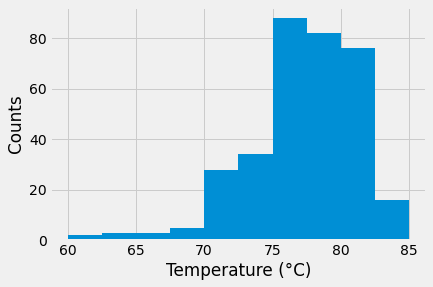

In [43]:
plt.hist(temperature)
plt.xlabel('Temperature (°C)')
plt.ylabel('Counts')
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
